### Neale Ellyson
## MSE 608: Project 8

In [48]:
import hoomd
import hoomd.md
import numpy
import ex_render
import freud 
import matplotlib.pyplot as plt
import time
%matplotlib inline
fractions = {}
data = {}
EQfrac = {}
EQdata = {}
analysis = {}
EQanalysis = {}

In [49]:
class rdf_analyze:
    def __init__(self, system):
        self.system = system;
        self.rdf = freud.density.RDF(rmax=1.0, dr=0.01); #Can update range and stepsize here
        
    def __call__(self, step):
        '''This special function defines what happens when we "register" the callback below'''
        snap = self.system.take_snapshot();
        pos = snap.particles.position;
        box = freud.box.Box(snap.box.Lx, snap.box.Ly, snap.box.Lz);
        self.rdf.accumulate(box, pos, pos);

In [50]:
def size(N): # Creates position vectors and bond groups for
    line = numpy.linspace(-(N//2-.5),(N//2-.5),num=N)
    position = numpy.insert(numpy.zeros((N,2)), 0, line, axis=1)
    a = numpy.repeat(numpy.arange(N),2)
    bondgroup = a[1:-1].reshape(len(a[1:-1])//2,2)
    return position,bondgroup

In [51]:
def run(aAB,N,fA,position,bondgroup,kT,tau,period,tsteps):
    fBN = int((1-fA)*N)
    hoomd.context.initialize("");
    # Mike says "This is initializing the longer way than a lattice"
    snapshot = hoomd.data.make_snapshot(N=N, # Number of atoms in a particle
                                        box=hoomd.data.boxdim(Lx=N, Ly=0.5, Lz=0.5),
                                        particle_types=['A', 'B'],
                                        bond_types=['polymer']); # Single bond type
    #print(snapshot.particles.position[:])
    #print(position)
    snapshot.particles.position[:] = position
    snapshot.particles.typeid[0:(fBN)]=0;  # Blue particles = A
    snapshot.particles.typeid[(fBN):N]=1; # Orange particles = B
    snapshot.bonds.resize(N-1);
    snapshot.bonds.group[:] = bondgroup
    snapshot.replicate(1,2*N,2*N); # Makes boxdim equal across the L dimensions
    hoomd.init.read_snapshot(snapshot);
    nl = hoomd.md.nlist.cell();
    dpd = hoomd.md.pair.dpd(r_cut=1.0, nlist=nl, kT=kT, seed=1); # NOT Dissipative Particle Dynamics, LJ
    dpd.pair_coeff.set('A', 'A', A=25.0, gamma = 1.0);
    dpd.pair_coeff.set('A', 'B', A=aAB, gamma = 1.0);
    dpd.pair_coeff.set('B', 'B', A=25.0, gamma = 1.0);
    nl.reset_exclusions(exclusions = []);
    harmonic = hoomd.md.bond.harmonic();
    harmonic.bond_coeff.set('polymer', k=100.0, r0=0);
    hoomd.md.integrate.mode_standard(dt=0.005);
    all = hoomd.group.all();
    integrator = hoomd.md.integrate.nvt(group=all,kT=kT,tau=tau);
    integrator.randomize_velocities(seed=42)
    hoomd.analyze.log(filename="rep-"+str(aAB)+"frac-"+str(fA)+".log",
                      quantities=['potential_energy','kinetic_energy','temperature','time'],
                      period=period ,
                      overwrite=True);
    hoomd.dump.gsd("traj-rep-"+str(aAB)+"frac-"+str(fA)+".gsd", period=tsteps/10 , group=all, overwrite=True);
    hoomd.run(tsteps);
    data = numpy.genfromtxt(fname="rep-"+str(aAB)+"frac-"+str(fA)+".log", skip_header=True);
    return data

In [52]:
def EQrun(aAB,kT,tau,period,tsteps):
    hoomd.context.initialize("");
    system = hoomd.init.read_gsd("traj-rep-"+str(aAB)+"frac-"+str(fA)+".gsd", frame=-1, time_step=0)
    EQanalysis = rdf_analyze(system); # Create the RDF analyzer using our class in the above cell
    hoomd.analyze.callback(EQanalysis, period=period); #Registration of the RDF callback every 100 steps
    nl = hoomd.md.nlist.cell();
    dpd = hoomd.md.pair.dpd(r_cut=1.0, nlist=nl, kT=kT, seed=1); # NOT Dissipative Particle Dynamics, LJ
    dpd.pair_coeff.set('A', 'A', A=25.0, gamma = 1.0);
    dpd.pair_coeff.set('A', 'B', A=aAB, gamma = 1.0);
    dpd.pair_coeff.set('B', 'B', A=25.0, gamma = 1.0);
    nl.reset_exclusions(exclusions = []);
    harmonic = hoomd.md.bond.harmonic();
    harmonic.bond_coeff.set('polymer', k=100.0, r0=0);
    hoomd.md.integrate.mode_standard(dt=0.005);
    all = hoomd.group.all();
    integrator = hoomd.md.integrate.nvt(group=all,kT=kT,tau=tau);
    integrator.randomize_velocities(seed=42)
    hoomd.analyze.log(filename="EQ-rep-"+str(aAB)+"frac-"+str(fA)+".log",
                      quantities=['potential_energy','kinetic_energy','temperature','time'],
                      period=period ,
                      overwrite=True);
    hoomd.dump.gsd("EQtraj-rep-"+str(aAB)+"frac-"+str(fA)+".gsd", period=tsteps/10 , group=all, overwrite=True);
    hoomd.run(tsteps);
    data = numpy.genfromtxt(fname="EQ-rep-"+str(aAB)+"frac-"+str(fA)+".log", skip_header=True);
    return data,EQanalysis

In [53]:
len(numpy.arange(250,2501,100))

23

In [54]:
#N = 10 # Must be at least 10 and an even number; 40,~5:56min; 30,~2:24min; 20,~0:38
kT = 1 # Using range 0.1<kT<10
Sizes = numpy.arange(10,51,100)
VolFrac = numpy.arange(0.1,0.6,0.1)
Repulsion = numpy.arange(250,2501,100)
tau = 0.1
period = 100
tsteps = 1e4
start = time.time()
for aAB in Repulsion:
    N = 10
    pos,bonds = size(N)
    onerun = []
    oneEQrun = []
    analysisrun = []
    for fA in VolFrac:
        print("\n Starting run with",N,"particles at a fraction of", fA,"\n")
        fractions[fA] = run(aAB,N,fA,pos,bonds,kT,tau,period,tsteps)
        onerun.append(fractions[fA])
        data[N] =  numpy.array(onerun)
        print("\n Starting Equilirbrium Run")
        EQfrac[fA],analysis[fA] = EQrun(aAB,kT,tau,period,tsteps)
        oneEQrun.append(EQfrac[fA])
        analysisrun.append(analysis[fA])
        EQdata[N] = numpy.array(oneEQrun)
        EQanalysis[N] = numpy.array(analysisrun)
finish = time.time()
print('This took',(finish-start)/60,'minutes, or',(finish-start)/60/60,'hours')


 Starting run with 10 particles at a fraction of 0.1 

notice(2): Group "all" created containing 4000 particles
-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 4000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 1041 / 10000 | TPS 104.097 | ETA 00:01:26
Time 00:00:20 | Step 2685 / 10000 | TPS 164.384 | ETA 00:00:44
Time 00:00:30 | Step 4390 / 10000 | TPS 170.3 | ETA 00:00:32
Time 00:00:40 | Step 6098 / 10000 | TPS 170.783 | ETA 00:00:22
Time 00:00:50 | Step 7824 / 10000 | TPS 172.576 | ETA 00:00:12
Time 00:01:00 | Step 9528 / 10000 | TPS 170.328 | 

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 4000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 990 / 10000 | TPS 98.998 | ETA 00:01:31
Time 00:00:20 | Step 2587 / 10000 | TPS 159.412 | ETA 00:00:46
Time 00:00:30 | Step 4261 / 10000 | TPS 167.346 | ETA 00:00:34
Time 00:00:40 | Step 5933 / 10000 | TPS 167.176 | ETA 00:00:24
Time 00:00:50 | Step 7671 / 10000 | TPS 173.778 | ETA 00:00:13
Time 00:01:00 | Step 9422 / 10000 | TPS 175.053 | ETA 00:00:03
Time 00:01:03 | Step 10000 / 10000 | TPS 175.582 | ETA 00:00:00
Average TPS: 157.928
---------
-- Neighborlist stats:
1001 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 50 / n_neigh_avg: 22.7963
shortest rebuild period: 5
-- Cell list stats:
Dimension: 7, 7, 7
n_min    : 6 / n_max: 18 / n_avg: 11.6618
** run complete **

 Starting Equilir

** starting run **
Time 00:00:10 | Step 1192 / 10000 | TPS 119.089 | ETA 00:01:13
Time 00:00:20 | Step 2914 / 10000 | TPS 172.171 | ETA 00:00:41
Time 00:00:30 | Step 4656 / 10000 | TPS 174.197 | ETA 00:00:30
Time 00:00:40 | Step 6388 / 10000 | TPS 173.022 | ETA 00:00:20
Time 00:00:50 | Step 8111 / 10000 | TPS 172.165 | ETA 00:00:10
Time 00:01:00 | Step 9835 / 10000 | TPS 172.359 | ETA 00:00:00
Time 00:01:01 | Step 10000 / 10000 | TPS 171.119 | ETA 00:00:00
Average TPS: 163.942
---------
-- Neighborlist stats:
1011 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 51 / n_neigh_avg: 22.8807
shortest rebuild period: 5
-- Cell list stats:
Dimension: 7, 7, 7
n_min    : 3 / n_max: 18 / n_avg: 11.6618
** run complete **

 Starting Equilirbrium Run
notice(2): Group "all" created containing 4000 particles
-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamic

Time 00:00:40 | Step 6350 / 10000 | TPS 175.149 | ETA 00:00:20
Time 00:00:50 | Step 8049 / 10000 | TPS 169.85 | ETA 00:00:11
Time 00:01:00 | Step 9760 / 10000 | TPS 171.074 | ETA 00:00:01
Time 00:01:01 | Step 10000 / 10000 | TPS 176.363 | ETA 00:00:00
Average TPS: 162.857
---------
-- Neighborlist stats:
1000 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 48 / n_neigh_avg: 22.779
shortest rebuild period: 5
-- Cell list stats:
Dimension: 7, 7, 7
n_min    : 5 / n_max: 18 / n_avg: 11.6618
** run complete **

 Starting Equilirbrium Run
notice(2): Group "all" created containing 4000 particles
-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 e

Time 00:01:00 | Step 10000 / 10000 | TPS 174.751 | ETA 00:00:00
Average TPS: 164.976
---------
-- Neighborlist stats:
1004 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 52 / n_neigh_avg: 22.9213
shortest rebuild period: 5
-- Cell list stats:
Dimension: 7, 7, 7
n_min    : 5 / n_max: 18 / n_avg: 11.6618
** run complete **

 Starting Equilirbrium Run
notice(2): Group "all" created containing 4000 particles
-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 4000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 1636 /

shortest rebuild period: 4
-- Cell list stats:
Dimension: 7, 7, 7
n_min    : 4 / n_max: 19 / n_avg: 11.6618
** run complete **

 Starting Equilirbrium Run
notice(2): Group "all" created containing 4000 particles
-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 4000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 1613 / 10000 | TPS 161.253 | ETA 00:00:52
Time 00:00:20 | Step 3345 / 10000 | TPS 173.166 | ETA 00:00:38
Time 00:00:30 | Step 5078 / 10000 | TPS 173.285 | ETA 00:00:28
Time 00:00:40 | Step 6814 / 10000 | TPS 173.53 | ETA 00:00:18
Time 00:00:50

-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 4000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 1637 / 10000 | TPS 163.654 | ETA 00:00:51
Time 00:00:20 | Step 3397 / 10000 | TPS 175.704 | ETA 00:00:37
Time 00:00:30 | Step 5151 / 10000 | TPS 175.349 | ETA 00:00:27
Time 00:00:40 | Step 6905 / 10000 | TPS 175.344 | ETA 00:00:17
Time 00:00:50 | Step 8655 / 10000 | TPS 174.864 | ETA 00:00:07
Time 00:00:57 | Step 10000 / 10000 | TPS 173.828 | ETA 00:00:00
Average TPS: 173.094
---------
-- Neighborlist stats:
988 normal updates / 100 forced updates / 0

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 4000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 1616 / 10000 | TPS 161.588 | ETA 00:00:51
Time 00:00:20 | Step 3357 / 10000 | TPS 174.08 | ETA 00:00:38
Time 00:00:30 | Step 5038 / 10000 | TPS 168.047 | ETA 00:00:29
Time 00:00:40 | Step 6784 / 10000 | TPS 174.58 | ETA 00:00:18
Time 00:00:50 | Step 8528 / 10000 | TPS 174.394 | ETA 00:00:08
Time 00:00:58 | Step 10000 / 10000 | TPS 173.359 | ETA 00:00:00
Average TPS: 170.945
---------
-- Neighborlist stats:
990 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 52 / n_neigh_avg: 22.877
shortest rebuild period: 7
-- Cell list stats:
Dimension: 7, 7, 7
n_min    : 6 / n_max: 17 / n_avg: 11.6618
** run complete **

 Starting run with 10 particles at a fraction of 0.30000000000000004 

notice(2): 

** starting run **
Time 00:00:10 | Step 1630 / 10000 | TPS 162.95 | ETA 00:00:51
Time 00:00:20 | Step 3392 / 10000 | TPS 176.158 | ETA 00:00:37
Time 00:00:30 | Step 5148 / 10000 | TPS 175.574 | ETA 00:00:27
Time 00:00:40 | Step 6901 / 10000 | TPS 175.125 | ETA 00:00:17
Time 00:00:50 | Step 8611 / 10000 | TPS 170.969 | ETA 00:00:08
Time 00:00:58 | Step 10000 / 10000 | TPS 172.811 | ETA 00:00:00
Average TPS: 172.244
---------
-- Neighborlist stats:
989 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 49 / n_neigh_avg: 22.7082
shortest rebuild period: 8
-- Cell list stats:
Dimension: 7, 7, 7
n_min    : 5 / n_max: 20 / n_avg: 11.6618
** run complete **

 Starting run with 10 particles at a fraction of 0.1 

notice(2): Group "all" created containing 4000 particles
-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics s

Time 00:00:40 | Step 6827 / 10000 | TPS 174.851 | ETA 00:00:18
Time 00:00:50 | Step 8577 / 10000 | TPS 174.991 | ETA 00:00:08
Time 00:00:58 | Step 10000 / 10000 | TPS 174.8 | ETA 00:00:00
Average TPS: 171.951
---------
-- Neighborlist stats:
990 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 53 / n_neigh_avg: 22.8848
shortest rebuild period: 8
-- Cell list stats:
Dimension: 7, 7, 7
n_min    : 4 / n_max: 19 / n_avg: 11.6618
** run complete **

 Starting run with 10 particles at a fraction of 0.4 

notice(2): Group "all" created containing 4000 particles
-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 4000
notice(

---------
-- Neighborlist stats:
991 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 53 / n_neigh_avg: 23.0643
shortest rebuild period: 7
-- Cell list stats:
Dimension: 7, 7, 7
n_min    : 5 / n_max: 21 / n_avg: 11.6618
** run complete **

 Starting run with 10 particles at a fraction of 0.2 

notice(2): Group "all" created containing 4000 particles
-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 4000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 1230 / 10000 | TPS 122.949 | ETA 00:01:11
Time 00:00:20 | Step 2

shortest rebuild period: 8
-- Cell list stats:
Dimension: 7, 7, 7
n_min    : 5 / n_max: 18 / n_avg: 11.6618
** run complete **

 Starting run with 10 particles at a fraction of 0.5 

notice(2): Group "all" created containing 4000 particles
-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 4000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 1224 / 10000 | TPS 122.35 | ETA 00:01:11
Time 00:00:20 | Step 2994 / 10000 | TPS 176.901 | ETA 00:00:39
Time 00:00:30 | Step 4701 / 10000 | TPS 170.442 | ETA 00:00:31
Time 00:00:40 | Step 6428 / 10000 | TPS 172.628 

-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 4000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 1209 / 10000 | TPS 120.784 | ETA 00:01:12
Time 00:00:20 | Step 2978 / 10000 | TPS 176.858 | ETA 00:00:39
Time 00:00:30 | Step 4670 / 10000 | TPS 169.191 | ETA 00:00:31
Time 00:00:40 | Step 6417 / 10000 | TPS 174.634 | ETA 00:00:20
Time 00:00:50 | Step 8167 / 10000 | TPS 174.834 | ETA 00:00:10
Time 00:01:00 | Step 9914 / 10000 | TPS 174.668 | ETA 00:00:00
Time 00:01:00 | Step 10000 / 10000 | TPS 177.506 | ETA 00:00:00
Average TPS: 165.253
---------
-- 

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 4000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 1177 / 10000 | TPS 117.667 | ETA 00:01:14
Time 00:00:20 | Step 2903 / 10000 | TPS 172.579 | ETA 00:00:41
Time 00:00:30 | Step 4564 / 10000 | TPS 166.032 | ETA 00:00:32
Time 00:00:40 | Step 6279 / 10000 | TPS 171.347 | ETA 00:00:21
Time 00:00:50 | Step 8007 / 10000 | TPS 172.749 | ETA 00:00:11
Time 00:01:00 | Step 9729 / 10000 | TPS 172.127 | ETA 00:00:01
Time 00:01:01 | Step 10000 / 10000 | TPS 174.605 | ETA 00:00:00
Average TPS: 162.398
---------
-- Neighborlist stats:
1015 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 52 / n_neigh_avg: 23.0742
shortest rebuild period: 4
-- Cell list stats:
Dimension: 7, 7, 7
n_min    : 5 / n_max: 20 / n_avg: 11.6618
** run complete **

 Starting Equil

** starting run **
Time 00:00:10 | Step 1213 / 10000 | TPS 121.283 | ETA 00:01:12
Time 00:00:20 | Step 2931 / 10000 | TPS 171.76 | ETA 00:00:41
Time 00:00:30 | Step 4613 / 10000 | TPS 168.177 | ETA 00:00:32
Time 00:00:40 | Step 6356 / 10000 | TPS 174.296 | ETA 00:00:20
Time 00:00:50 | Step 8119 / 10000 | TPS 175.993 | ETA 00:00:10
Time 00:01:00 | Step 9849 / 10000 | TPS 172.931 | ETA 00:00:00
Time 00:01:00 | Step 10000 / 10000 | TPS 172.556 | ETA 00:00:00
Average TPS: 164.196
---------
-- Neighborlist stats:
993 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 53 / n_neigh_avg: 22.8382
shortest rebuild period: 5
-- Cell list stats:
Dimension: 7, 7, 7
n_min    : 4 / n_max: 21 / n_avg: 11.6618
** run complete **

 Starting Equilirbrium Run
notice(2): Group "all" created containing 4000 particles
-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics 

Time 00:00:40 | Step 6338 / 10000 | TPS 172.33 | ETA 00:00:21
Time 00:00:50 | Step 8077 / 10000 | TPS 173.85 | ETA 00:00:11
Time 00:01:00 | Step 9811 / 10000 | TPS 173.268 | ETA 00:00:01
Time 00:01:01 | Step 10000 / 10000 | TPS 177.127 | ETA 00:00:00
Average TPS: 163.7
---------
-- Neighborlist stats:
994 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 52 / n_neigh_avg: 22.9357
shortest rebuild period: 5
-- Cell list stats:
Dimension: 7, 7, 7
n_min    : 5 / n_max: 18 / n_avg: 11.6618
** run complete **

 Starting Equilirbrium Run
notice(2): Group "all" created containing 4000 particles
-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 excl

Average TPS: 164.128
---------
-- Neighborlist stats:
1001 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 53 / n_neigh_avg: 22.7538
shortest rebuild period: 5
-- Cell list stats:
Dimension: 7, 7, 7
n_min    : 6 / n_max: 19 / n_avg: 11.6618
** run complete **

 Starting Equilirbrium Run
notice(2): Group "all" created containing 4000 particles
-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 4000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 1591 / 10000 | TPS 158.88 | ETA 00:00:52
Time 00:00:20 | Step 3345 / 1

-- Cell list stats:
Dimension: 7, 7, 7
n_min    : 5 / n_max: 18 / n_avg: 11.6618
** run complete **

 Starting Equilirbrium Run
notice(2): Group "all" created containing 4000 particles
-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 4000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 1549 / 10000 | TPS 154.871 | ETA 00:00:54
Time 00:00:20 | Step 3300 / 10000 | TPS 174.9 | ETA 00:00:38
Time 00:00:30 | Step 4993 / 10000 | TPS 169.265 | ETA 00:00:29
Time 00:00:40 | Step 6700 / 10000 | TPS 170.613 | ETA 00:00:19
Time 00:00:50 | Step 8448 / 10000 | TPS 1

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 4000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 1514 / 10000 | TPS 151.356 | ETA 00:00:56
Time 00:00:20 | Step 3247 / 10000 | TPS 173.282 | ETA 00:00:38
Time 00:00:30 | Step 4971 / 10000 | TPS 172.398 | ETA 00:00:29
Time 00:00:40 | Step 6701 / 10000 | TPS 172.874 | ETA 00:00:19
Time 00:00:50 | Step 8435 / 10000 | TPS 173.389 | ETA 00:00:09
Time 00:00:59 | Step 10000 / 10000 | TPS 172.42 | ETA 00:00:00
Average TPS: 169.234
---------
-- Neighborlist stats:
992 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 54 / n_neigh_avg: 23.0825
shortest rebuild period: 7
-- Cell list stats:
Dimension: 7, 7, 7
n_min    : 4 / n_max: 18 / n_avg: 11.6618
** run complete **

 Starting run with 10 particles at a fraction of 0.2 

notice(2): Group "all" cr

** starting run **
Time 00:00:10 | Step 1524 / 10000 | TPS 152.345 | ETA 00:00:55
Time 00:00:20 | Step 3278 / 10000 | TPS 175.334 | ETA 00:00:38
Time 00:00:30 | Step 5020 / 10000 | TPS 174.178 | ETA 00:00:28
Time 00:00:40 | Step 6770 / 10000 | TPS 174.98 | ETA 00:00:18
Time 00:00:50 | Step 8512 / 10000 | TPS 174.171 | ETA 00:00:08
Time 00:00:58 | Step 10000 / 10000 | TPS 174.616 | ETA 00:00:00
Average TPS: 170.841
---------
-- Neighborlist stats:
990 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 53 / n_neigh_avg: 22.8947
shortest rebuild period: 7
-- Cell list stats:
Dimension: 7, 7, 7
n_min    : 7 / n_max: 19 / n_avg: 11.6618
** run complete **

 Starting run with 10 particles at a fraction of 0.5 

notice(2): Group "all" created containing 4000 particles
-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics s

Time 00:00:40 | Step 6656 / 10000 | TPS 165.462 | ETA 00:00:20
Time 00:00:50 | Step 8378 / 10000 | TPS 172.149 | ETA 00:00:09
Time 00:00:59 | Step 10000 / 10000 | TPS 171.719 | ETA 00:00:00
Average TPS: 168.149
---------
-- Neighborlist stats:
993 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 51 / n_neigh_avg: 22.9312
shortest rebuild period: 7
-- Cell list stats:
Dimension: 7, 7, 7
n_min    : 4 / n_max: 20 / n_avg: 11.6618
** run complete **

 Starting run with 10 particles at a fraction of 0.30000000000000004 

notice(2): Group "all" created containing 4000 particles
-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions         

Time 00:00:58 | Step 10000 / 10000 | TPS 175.467 | ETA 00:00:00
Average TPS: 171.337
---------
-- Neighborlist stats:
986 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 54 / n_neigh_avg: 22.7527
shortest rebuild period: 8
-- Cell list stats:
Dimension: 7, 7, 7
n_min    : 4 / n_max: 19 / n_avg: 11.6618
** run complete **

 Starting run with 10 particles at a fraction of 0.1 

notice(2): Group "all" created containing 4000 particles
-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 4000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **


shortest rebuild period: 8
-- Cell list stats:
Dimension: 7, 7, 7
n_min    : 5 / n_max: 19 / n_avg: 11.6618
** run complete **

 Starting run with 10 particles at a fraction of 0.4 

notice(2): Group "all" created containing 4000 particles
-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 4000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 1207 / 10000 | TPS 120.689 | ETA 00:01:12
Time 00:00:20 | Step 2896 / 10000 | TPS 168.849 | ETA 00:00:42
Time 00:00:30 | Step 4642 / 10000 | TPS 174.598 | ETA 00:00:30
Time 00:00:40 | Step 6403 / 10000 | TPS 176 | E

-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 4000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 1184 / 10000 | TPS 118.395 | ETA 00:01:14
Time 00:00:20 | Step 2832 / 10000 | TPS 164.745 | ETA 00:00:43
Time 00:00:30 | Step 4559 / 10000 | TPS 172.683 | ETA 00:00:31
Time 00:00:40 | Step 6309 / 10000 | TPS 174.929 | ETA 00:00:21
Time 00:00:50 | Step 8033 / 10000 | TPS 172.349 | ETA 00:00:11
Time 00:01:00 | Step 9767 / 10000 | TPS 173.169 | ETA 00:00:01
Time 00:01:01 | Step 10000 / 10000 | TPS 175.595 | ETA 00:00:00
Average TPS: 162.99
---------
-- N

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 4000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 1191 / 10000 | TPS 119.02 | ETA 00:01:14
Time 00:00:20 | Step 2866 / 10000 | TPS 167.441 | ETA 00:00:42
Time 00:00:30 | Step 4589 / 10000 | TPS 172.267 | ETA 00:00:31
Time 00:00:40 | Step 6337 / 10000 | TPS 174.763 | ETA 00:00:20
Time 00:00:50 | Step 8078 / 10000 | TPS 173.896 | ETA 00:00:11
Time 00:01:00 | Step 9830 / 10000 | TPS 174.903 | ETA 00:00:00
Time 00:01:01 | Step 10000 / 10000 | TPS 176.739 | ETA 00:00:00
Average TPS: 163.918
---------
-- Neighborlist stats:
996 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 53 / n_neigh_avg: 22.7958
shortest rebuild period: 5
-- Cell list stats:
Dimension: 7, 7, 7
n_min    : 6 / n_max: 19 / n_avg: 11.6618
** run complete **

 Starting Equilir

notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 1157 / 10000 | TPS 115.544 | ETA 00:01:16
Time 00:00:20 | Step 2820 / 10000 | TPS 166.275 | ETA 00:00:43
Time 00:00:30 | Step 4559 / 10000 | TPS 173.739 | ETA 00:00:31
Time 00:00:40 | Step 6301 / 10000 | TPS 174.178 | ETA 00:00:21
Time 00:00:50 | Step 8041 / 10000 | TPS 173.95 | ETA 00:00:11
Time 00:01:00 | Step 9789 / 10000 | TPS 174.576 | ETA 00:00:01
Time 00:01:01 | Step 10000 / 10000 | TPS 175.418 | ETA 00:00:00
Average TPS: 163.278
---------
-- Neighborlist stats:
1000 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 56 / n_neigh_avg: 22.962
shortest rebuild period: 5
-- Cell list stats:
Dimension: 7, 7, 7
n_min    : 6 / n_max: 18 / n_avg: 11.6618
** run complete **

 Starting Equilirbrium Run
notice(2): Group "all" created containing 4000 particles
-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "

Time 00:00:40 | Step 6249 / 10000 | TPS 172.987 | ETA 00:00:21
Time 00:00:50 | Step 7898 / 10000 | TPS 164.883 | ETA 00:00:12
Time 00:01:00 | Step 9607 / 10000 | TPS 170.859 | ETA 00:00:02
Time 00:01:02 | Step 10000 / 10000 | TPS 174.009 | ETA 00:00:00
Average TPS: 160.556
---------
-- Neighborlist stats:
1013 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 53 / n_neigh_avg: 23.106
shortest rebuild period: 5
-- Cell list stats:
Dimension: 7, 7, 7
n_min    : 5 / n_max: 20 / n_avg: 11.6618
** run complete **

 Starting Equilirbrium Run
notice(2): Group "all" created containing 4000 particles
-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 

Time 00:01:00 | Step 10000 / 10000 | TPS 177.09 | ETA 00:00:00
Average TPS: 164.156
---------
-- Neighborlist stats:
995 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 51 / n_neigh_avg: 22.9108
shortest rebuild period: 5
-- Cell list stats:
Dimension: 7, 7, 7
n_min    : 5 / n_max: 18 / n_avg: 11.6618
** run complete **

 Starting Equilirbrium Run
notice(2): Group "all" created containing 4000 particles
-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 4000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 1537 / 1

shortest rebuild period: 5
-- Cell list stats:
Dimension: 7, 7, 7
n_min    : 6 / n_max: 18 / n_avg: 11.6618
** run complete **

 Starting Equilirbrium Run
notice(2): Group "all" created containing 4000 particles
-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 4000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 1543 / 10000 | TPS 154.258 | ETA 00:00:54
Time 00:00:20 | Step 3205 / 10000 | TPS 166.167 | ETA 00:00:40
Time 00:00:30 | Step 4940 / 10000 | TPS 173.477 | ETA 00:00:29
Time 00:00:40 | Step 6657 / 10000 | TPS 171.693 | ETA 00:00:19
Time 00:00:5

-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 4000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 1520 / 10000 | TPS 151.769 | ETA 00:00:55
Time 00:00:20 | Step 3260 / 10000 | TPS 173.989 | ETA 00:00:38
Time 00:00:30 | Step 5001 / 10000 | TPS 173.853 | ETA 00:00:28
Time 00:00:40 | Step 6724 / 10000 | TPS 172.254 | ETA 00:00:19
Time 00:00:50 | Step 8458 / 10000 | TPS 173.344 | ETA 00:00:08
Time 00:00:58 | Step 10000 / 10000 | TPS 174.8 | ETA 00:00:00
Average TPS: 169.899
---------
-- Neighborlist stats:
984 normal updates / 100 forced updates / 0 d

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 4000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 1555 / 10000 | TPS 155.482 | ETA 00:00:54
Time 00:00:20 | Step 3301 / 10000 | TPS 174.294 | ETA 00:00:38
Time 00:00:30 | Step 5050 / 10000 | TPS 174.708 | ETA 00:00:28
Time 00:00:40 | Step 6801 / 10000 | TPS 174.87 | ETA 00:00:18
Time 00:00:50 | Step 8544 / 10000 | TPS 174.283 | ETA 00:00:08
Time 00:00:58 | Step 10000 / 10000 | TPS 175.033 | ETA 00:00:00
Average TPS: 171.341
---------
-- Neighborlist stats:
987 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 55 / n_neigh_avg: 22.9333
shortest rebuild period: 6
-- Cell list stats:
Dimension: 7, 7, 7
n_min    : 6 / n_max: 20 / n_avg: 11.6618
** run complete **

 Starting run with 10 particles at a fraction of 0.4 

notice(2): Group "all" cr

** starting run **
Time 00:00:10 | Step 1467 / 10000 | TPS 146.597 | ETA 00:00:58
Time 00:00:20 | Step 3198 / 10000 | TPS 173.03 | ETA 00:00:39
Time 00:00:30 | Step 4911 / 10000 | TPS 171.211 | ETA 00:00:29
Time 00:00:40 | Step 6629 / 10000 | TPS 171.498 | ETA 00:00:19
Time 00:00:50 | Step 8367 / 10000 | TPS 173.753 | ETA 00:00:09
Time 00:01:00 | Step 10000 / 10000 | TPS 163.238 | ETA 00:00:00
Average TPS: 166.552
---------
-- Neighborlist stats:
991 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 53 / n_neigh_avg: 23.141
shortest rebuild period: 8
-- Cell list stats:
Dimension: 7, 7, 7
n_min    : 5 / n_max: 18 / n_avg: 11.6618
** run complete **

 Starting run with 10 particles at a fraction of 0.2 

notice(2): Group "all" created containing 4000 particles
-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics si

Time 00:00:30 | Step 4980 / 10000 | TPS 173.072 | ETA 00:00:29
Time 00:00:40 | Step 6704 / 10000 | TPS 172.345 | ETA 00:00:19
Time 00:00:50 | Step 8430 / 10000 | TPS 172.248 | ETA 00:00:09
Time 00:00:59 | Step 10000 / 10000 | TPS 163.523 | ETA 00:00:00
Average TPS: 167.679
---------
-- Neighborlist stats:
986 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 53 / n_neigh_avg: 22.7963
shortest rebuild period: 7
-- Cell list stats:
Dimension: 7, 7, 7
n_min    : 6 / n_max: 20 / n_avg: 11.6618
** run complete **

 Starting run with 10 particles at a fraction of 0.5 

notice(2): Group "all" created containing 4000 particles
-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----
notice(2): -- Neighborlist exclusion statistics -- :


Time 00:01:00 | Step 10000 / 10000 | TPS 163.445 | ETA 00:00:00
Average TPS: 166.293
---------
-- Neighborlist stats:
987 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 55 / n_neigh_avg: 22.9127
shortest rebuild period: 7
-- Cell list stats:
Dimension: 7, 7, 7
n_min    : 4 / n_max: 21 / n_avg: 11.6618
** run complete **

 Starting run with 10 particles at a fraction of 0.30000000000000004 

notice(2): Group "all" created containing 4000 particles
-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 4000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** 

shortest rebuild period: 7
-- Cell list stats:
Dimension: 7, 7, 7
n_min    : 4 / n_max: 19 / n_avg: 11.6618
** run complete **

 Starting run with 10 particles at a fraction of 0.1 

notice(2): Group "all" created containing 4000 particles
-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 4000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 1127 / 10000 | TPS 112.683 | ETA 00:01:18
Time 00:00:20 | Step 2860 / 10000 | TPS 173.281 | ETA 00:00:41
Time 00:00:30 | Step 4546 / 10000 | TPS 168.54 | ETA 00:00:32
Time 00:00:40 | Step 6243 / 10000 | TPS 169.634 


 Starting run with 10 particles at a fraction of 0.4 

notice(2): Group "all" created containing 4000 particles
-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 4000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 1122 / 10000 | TPS 112.192 | ETA 00:01:19
Time 00:00:20 | Step 2860 / 10000 | TPS 173.745 | ETA 00:00:41
Time 00:00:30 | Step 4597 / 10000 | TPS 173.69 | ETA 00:00:31
Time 00:00:40 | Step 6351 / 10000 | TPS 175.156 | ETA 00:00:20
Time 00:00:50 | Step 8096 / 10000 | TPS 174.435 | ETA 00:00:10
Time 00:01:00 | Step 9828 / 10000 | TPS 173.054 |

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 4000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 1125 / 10000 | TPS 112.494 | ETA 00:01:18
Time 00:00:20 | Step 2854 / 10000 | TPS 172.871 | ETA 00:00:41
Time 00:00:30 | Step 4595 / 10000 | TPS 174.081 | ETA 00:00:31
Time 00:00:40 | Step 6340 / 10000 | TPS 174.316 | ETA 00:00:20
Time 00:00:50 | Step 8020 / 10000 | TPS 167.742 | ETA 00:00:11
Time 00:01:00 | Step 9765 / 10000 | TPS 174.457 | ETA 00:00:01
Time 00:01:01 | Step 10000 / 10000 | TPS 171.644 | ETA 00:00:00
Average TPS: 162.861
---------
-- Neighborlist stats:
999 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 53 / n_neigh_avg: 22.9277
shortest rebuild period: 5
-- Cell list stats:
Dimension: 7, 7, 7
n_min    : 4 / n_max: 18 / n_avg: 11.6618
** run complete **

 Starting Equili

notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 1063 / 10000 | TPS 106.163 | ETA 00:01:24
Time 00:00:20 | Step 2803 / 10000 | TPS 173.972 | ETA 00:00:41
Time 00:00:30 | Step 4553 / 10000 | TPS 174.929 | ETA 00:00:31
Time 00:00:40 | Step 6311 / 10000 | TPS 175.49 | ETA 00:00:21
Time 00:00:50 | Step 8055 / 10000 | TPS 174.377 | ETA 00:00:11
Time 00:01:00 | Step 9799 / 10000 | TPS 174.397 | ETA 00:00:01
Time 00:01:01 | Step 10000 / 10000 | TPS 173.476 | ETA 00:00:00
Average TPS: 163.404
---------
-- Neighborlist stats:
996 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 51 / n_neigh_avg: 22.781
shortest rebuild period: 5
-- Cell list stats:
Dimension: 7, 7, 7
n_min    : 6 / n_max: 19 / n_avg: 11.6618
** run complete **

 Starting Equilirbrium Run
notice(2): Group "all" created containing 4000 particles
-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "P

Here's a calc of chi
$$ \chi = \frac{2\alpha(a_{AB}-a_{AA})(\rho_A +\rho_B)}{k_BT}$$
$$ \alpha = 0.101 \pm  0.001$$
From Dissipative particle dynamics: Bridging the gap between atomistic and mesoscopic simulation, Groot & Warren

In [ ]:
print([1/6,2/7,3/8,4/9,5/10])
N = 10
dens = 1/(4/3*numpy.pi*0.5**3)*N # pA + pB, where particles have mass & diameter of 1
alpha = 0.101
aAB = 100
aAA = 25
kT = 1
chi = 2*alpha*(aAB-aAA)*dens/kT
print(chi)
print(chi*N)

In [ ]:
plt.figure()
plt.plot(data[10][0][:,0],data[10][0][:,1],label='kT=0.01',color='#4888db')
#plt.plot(data[10][1][:,0],data[10][1][:,1],label='kT=1.7575',color='#f79501')
#plt.plot(data[10][-1][:,0],data[10][-1][:,1],label='kT=7',color='#c63939')
plt.xlabel('time step')
plt.ylabel('potential_energy')
plt.legend()

In [ ]:
plt.figure()
plt.plot(data[10][0][:,0],data[10][0][:,1]+data[10][0][:,2],label='kT=0.01',color='#4888db')
#plt.plot(data[10][1][:,0],data[10][1][:,1]+data[10][1][:,2],label='kT=kT=1.7575',color='#f79501')
#plt.plot(data[10][-1][:,0],data[10][-1][:,1]+data[10][-1][:,2],label='kT=7',color='#c63939')
plt.xlabel('time step')
plt.ylabel('total_energy')
plt.legend()

In [ ]:
plt.figure()
Sizes = numpy.arange(5,11,5)#numpy.arange(5,11,1)
for N in Sizes:
    plt.plot(EQanalysis[N][0].rdf.R, EQanalysis[N][0].rdf.RDF,label=f"N={N}")
#plt.plot(EQanalysis[10][1].rdf.R, EQanalysis[10][1].rdf.RDF,label='kT=1.7575',color='#f79501')
#plt.plot(EQanalysis[10][-1].rdf.R, EQanalysis[10][-1].rdf.RDF,label='kT=7',color='#c63939')
plt.legend()
plt.xlabel('r')
plt.ylabel('g_AA')

In [ ]:
## Add in read csv for sq text files within testN folder and plot those babies. So txt files in S(q) v q, 
## where q = 2.pi/L, we want S(q) in log plot and q/2.pi to compare to paper

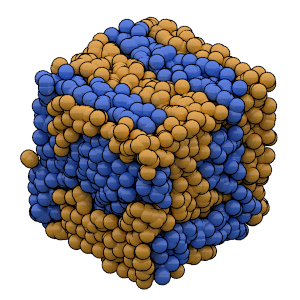

In [41]:
N = 10
fA = 0.5
ex_render.display_movie(ex_render.render_sphere_frame, "EQtraj-size-"+str(N)+"frac-"+str(fA)+".gsd") # Takes some time

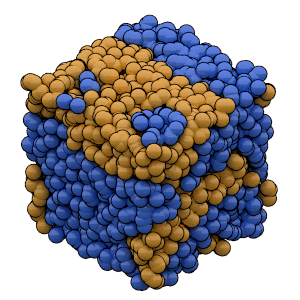

In [42]:
N = 10
fA = 0.4
ex_render.display_movie(ex_render.render_sphere_frame, "EQtraj-size-"+str(N)+"frac-"+str(fA)+".gsd") # Takes some time

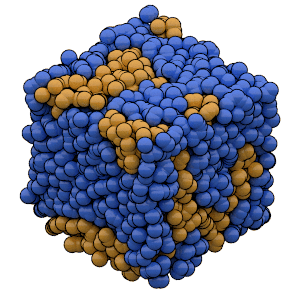

In [43]:
N = 10
fA = 0.30000000000000004
ex_render.display_movie(ex_render.render_sphere_frame, "EQtraj-size-"+str(N)+"frac-"+str(fA)+".gsd") # Takes some time

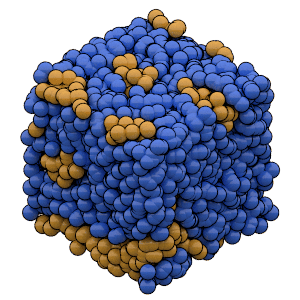

In [44]:
N = 10
fA = 0.2
ex_render.display_movie(ex_render.render_sphere_frame, "EQtraj-size-"+str(N)+"frac-"+str(fA)+".gsd") # Takes some time

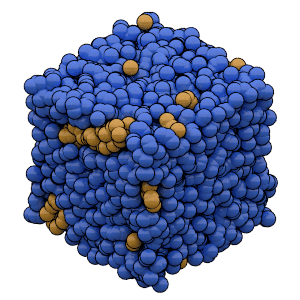

In [45]:
N = 10
fA = 0.1
ex_render.display_movie(ex_render.render_sphere_frame, "EQtraj-size-"+str(N)+"frac-"+str(fA)+".gsd") # Takes some time